In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime, date, timedelta

# Reflect Tables into SQLAlchemy ORM

In [65]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc, asc

In [5]:
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")
inspector = inspect(engine)

In [6]:
engine.table_names()

['measurement', 'station']

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Getting column names
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [262]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
from sqlalchemy import text

# Finding the last date in the data
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# pulling date from a year earlier than the 8/23/2017 returned above
one_year_earlier = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

# Creating SQL query and dropping it into a dataframe

df = pd.DataFrame(session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_earlier).\
    order_by(Measurement.date).all())

# Fix column names for upcoming graph
df.rename(columns = {'prcp': 'Precipitation', 'date': 'Date'}, inplace = True)

# Set Date as index
df.set_index('Date', inplace = True)
df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


In [263]:
# Sort the dataframe by date
df.sort_index(inplace = True)
df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


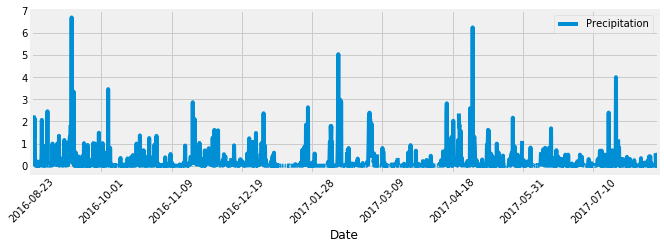

In [300]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize = (10,3), rot = 45)

In [265]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [85]:
# Getting column names for station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [216]:
# Design a query to show how many stations are available in this dataset
no_of_stations = session.query(Station.id).count()
print(f"There are {no_of_stations} stations in this dataset.")

There are 9 stations in this dataset.


In [366]:
station_names = session.query(Station.station).all()
[print(station.station) for station in station_names]

USC00519397
USC00513117
USC00514830
USC00517948
USC00518838
USC00519523
USC00519281
USC00511918
USC00516128


[None, None, None, None, None, None, None, None, None]

In [71]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

most_active = session.query(Measurement.station, func.count(Measurement.station))\
                .group_by(Measurement.station)\
                .order_by(func.count(Measurement.station).desc())\
                .all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [329]:
# Get the most active station's number from the first tuple
most_active_station = most_active[0][0]
most_active_station

'USC00519281'

In [337]:
# Query specific to the most active station
temperatures = session.query(Measurement.station, 
                         func.min(Measurement.tobs), 
                         func.max(Measurement.tobs),
                         func.avg(Measurement.tobs))\
                .filter(Measurement.station == most_active_station)\
                .group_by(Measurement.station)\
                .order_by(func.count(Measurement.station).desc())\
                .all()

temperatures

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [340]:
# Pulling values out of the tuple 
station_id = temperatures[0][0]
min_temp = temperatures[0][1]
max_temp = temperatures[0][2]
avg_temp = round(temperatures[0][3],2)

# Printout
print(f"Station {station_id} has a minimum temperature of {min_temp}, a maximum temperature of {max_temp},\n and an average temperature of {avg_temp}.")

Station USC00519281 has a minimum temperature of 54.0, a maximum temperature of 85.0,
 and an average temperature of 71.66.


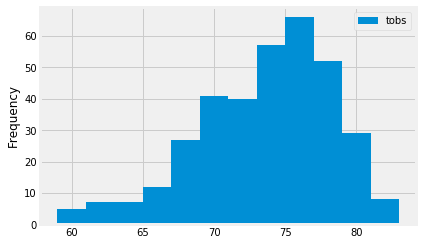

In [260]:
# Query the last 12 months of temperature observation data for the most active station and 
# plot the results as a histogram

temp_12_mos = pd.DataFrame(session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date > one_year_earlier).\
    order_by(Measurement.date).all())

temp_12_mos.plot.hist(bins=12)

In [130]:
# I'd like to make a dataframe of all the stations and their temperatures, so I'm pulling this data 
# with a more general query
temperatures = session.query(Measurement.station, 
                         func.min(Measurement.tobs), 
                         func.max(Measurement.tobs),
                         func.avg(Measurement.tobs))\
                .group_by(Measurement.station)\
                .order_by(func.count(Measurement.station).desc())\
                .all()

In [131]:
# From the query above, these are ordered by most active station to least active station
temperatures

[('USC00519281', 54.0, 85.0, 71.66378066378067),
 ('USC00519397', 56.0, 87.0, 74.55323054331865),
 ('USC00513117', 59.0, 85.0, 72.68918420081211),
 ('USC00519523', 56.0, 85.0, 74.5436493068565),
 ('USC00516128', 58.0, 84.0, 70.91500765696784),
 ('USC00514830', 58.0, 85.0, 74.8732970027248),
 ('USC00511918', 53.0, 87.0, 71.61596766043456),
 ('USC00517948', 58.0, 87.0, 74.68440233236151),
 ('USC00518838', 58.0, 83.0, 72.72407045009784)]

In [196]:
# To drop these into a dataframe, I'll need to get the elements out of the tuples by calling them by position
# First I'll create empty lists for the columns
col1 = []
col2 = []
col3 = []
col4 = []

# Next I'll pull the elements using list comprehension
[col1.append(station[0]) for station in temperatures]
[col2.append(station[1]) for station in temperatures]
[col3.append(station[2]) for station in temperatures]

# Rounding the average temperature as it's appended
[col4.append(round(station[3],2)) for station in temperatures]

# To get a column of the activity, I can examine the most_active variable returned two queries above
col5 = []
[col5.append(station[1]) for station in most_active]

[None, None, None, None, None, None, None, None, None]

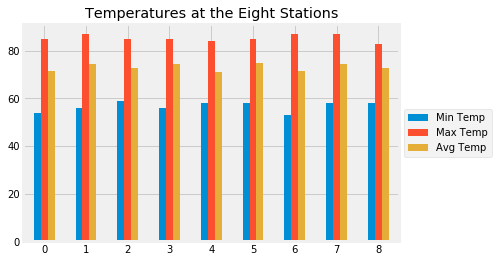

In [356]:
# Making a dataframe of the temperatures and doing a quick visualization

temps_df = pd.DataFrame()
temps_df["Station"] = col1
temps_df["Min Temp"] = col2
temps_df["Max Temp"] = col3
temps_df["Avg Temp"] = col4

# A quick visualization of temperatures
temps_df.plot.bar(title = "Temperatures at the Eight Stations", rot = 0)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [344]:
# Adding the measurements column
temps_df["Observations"] = col5
temps_df.head()

,Station,Min Temp,Max Temp,Avg Temp,Measurements,Observations
0,USC00519281,54.0,85.0,71.66,2772,2772
1,USC00519397,56.0,87.0,74.55,2724,2724
2,USC00513117,59.0,85.0,72.69,2709,2709
3,USC00519523,56.0,85.0,74.54,2669,2669
4,USC00516128,58.0,84.0,70.92,2612,2612


In [186]:
# Making a dataframe of the stations table so I can merge it with the temperatures dataframe
stations_df = pd.read_sql("SELECT * FROM station", engine)
stations_df

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [346]:
# Combining temps with station table
temp_df = temps_df.rename(columns = {'Station': 'station'})
combined_df = pd.merge(temp_df, stations_df, on = 'station')

# Sorting by id and setting it as the index
combined_df.sort_values('id', inplace = True)
combined_df.set_index('id', inplace = True)

# Renaming columns
cols = {'station': 'Station', 'name': 'Name', 'latitude':'Latitude', 
        'longitude': 'Longitude', 'elevation': 'Elevation'}

combined_df = combined_df.rename(columns = cols)

# Reordering columns
col_order = ['Station', 'Name', 'Latitude', 'Longitude', 'Elevation', 'Observations', 'Min Temp',
            'Max Temp', 'Avg Temp']
combined_df = combined_df[col_order]

# Nice-looking dataframe
combined_df

,Station,Name,Latitude,Longitude,Elevation,Observations,Min Temp,Max Temp,Avg Temp
id,,,,,,,,,
1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2724,56.0,87.0,74.55
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2709,59.0,85.0,72.69
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2202,58.0,85.0,74.87
4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,1372,58.0,87.0,74.68
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,511,58.0,83.0,72.72
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2669,56.0,85.0,74.54
7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2772,54.0,85.0,71.66
8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,1979,53.0,87.0,71.62
9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2612,58.0,84.0,70.92


In [261]:
temp_12_mos.head()

,station,date,tobs
0,USC00519281,2016-08-24,77.0
1,USC00519281,2016-08-25,80.0
2,USC00519281,2016-08-26,80.0
3,USC00519281,2016-08-27,75.0
4,USC00519281,2016-08-28,73.0


In [243]:
# This function called `calc_temps` will accept start date and end date in the format
#'%Y-%m-%d'and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the fou rmat %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [368]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Researching a trip with dates from June 20 - June 30

trip = (calc_temps('2017-06-20', '2017-06-30'))
trip

print(f"Minimum temp is {trip[0][0]}, maximum temp is {trip[0][2]}, and average temp is {trip[0][1]}.")

Minimum temp is 71.0, maximum temp is 82.0, and average temp is 77.07352941176471.


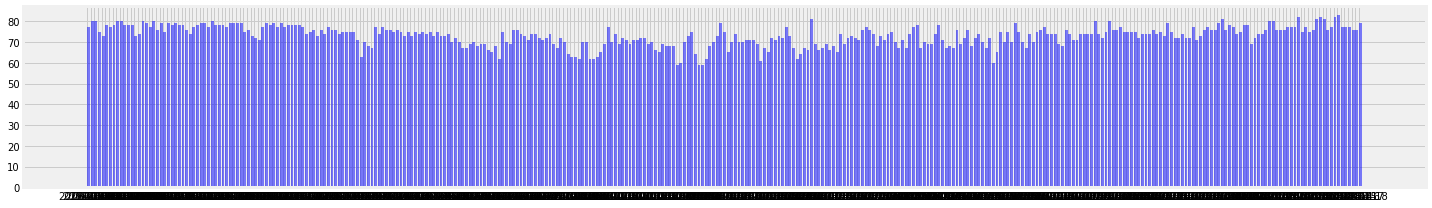

In [270]:
x_axis = temp_12_mos.date
# tick_locations = [value+0.4 for value in x_axis]
plt.figure(figsize=(20,3))

plt.bar(x_axis, temp_12_mos["tobs"], color='blue', alpha=0.5, align="edge")
# plt.xticks(tick_locations,temp_12_mos["prcp"], rotation="vertical")

plt.tight_layout()

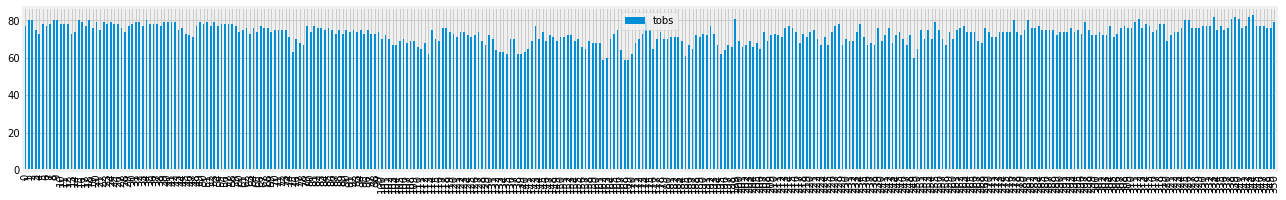

In [295]:
temp_12_mos.plot.bar(figsize=(20,3), rot = 90)

In [361]:
# Preparation for Flask

# Convert first query results to a dictionary using date as key and prcp as value
precip_dictionary = dict(df)

# Weirdly (probably because I set date as index), the key is called 'Precipitition' even though it's really the date.
# Fixed here:
precip_dictionary['date'] = precip_dictionary.pop('Precipitation')
# precip_dictionary.values()

from flask import jsonify
df.to_dict()

{'Precipitation': {'2016-08-23': 0.7,
  '2016-08-24': 1.45,
  '2016-08-25': 0.11,
  '2016-08-26': 0.01,
  '2016-08-27': nan,
  '2016-08-28': 2.07,
  '2016-08-29': 0.9,
  '2016-08-30': 0.05,
  '2016-08-31': 2.46,
  '2016-09-01': 0.01,
  '2016-09-02': 0.03,
  '2016-09-03': 1.0,
  '2016-09-04': 0.44,
  '2016-09-05': 0.18,
  '2016-09-06': 1.0,
  '2016-09-07': 1.35,
  '2016-09-08': 0.15,
  '2016-09-09': 0.35,
  '2016-09-10': 1.16,
  '2016-09-11': 0.6,
  '2016-09-12': 1.04,
  '2016-09-13': 1.2,
  '2016-09-14': 6.7,
  '2016-09-15': 3.35,
  '2016-09-16': 0.61,
  '2016-09-17': 0.23,
  '2016-09-18': 0.42,
  '2016-09-19': 0.25,
  '2016-09-20': 0.43,
  '2016-09-21': 1.02,
  '2016-09-22': 0.75,
  '2016-09-23': 0.33,
  '2016-09-24': 0.27,
  '2016-09-25': 0.04,
  '2016-09-26': 1.02,
  '2016-09-27': 1.0,
  '2016-09-28': 0.05,
  '2016-09-29': 1.49,
  '2016-09-30': 0.38,
  '2016-10-01': 1.02,
  '2016-10-02': 0.61,
  '2016-10-03': 0.46,
  '2016-10-04': 3.46,
  '2016-10-05': 0.81,
  '2016-10-06': 0.04,
  

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

In [259]:
# x_axis = temp_12_mos.date
# tick_locations = [value+0.4 for value in x_axis]
plt.figure(figsize=(20,3))

plt.bar(x_axis, temp_12_mos["prcp"], color='blue', alpha=0.5, align="edge")
# plt.xticks(tick_locations,temp_12_mos["prcp"], rotation="vertical")

plt.tight_layout()


AttributeError: 'list' object has no attribute 'plot'

<IPython.core.display.Javascript object>


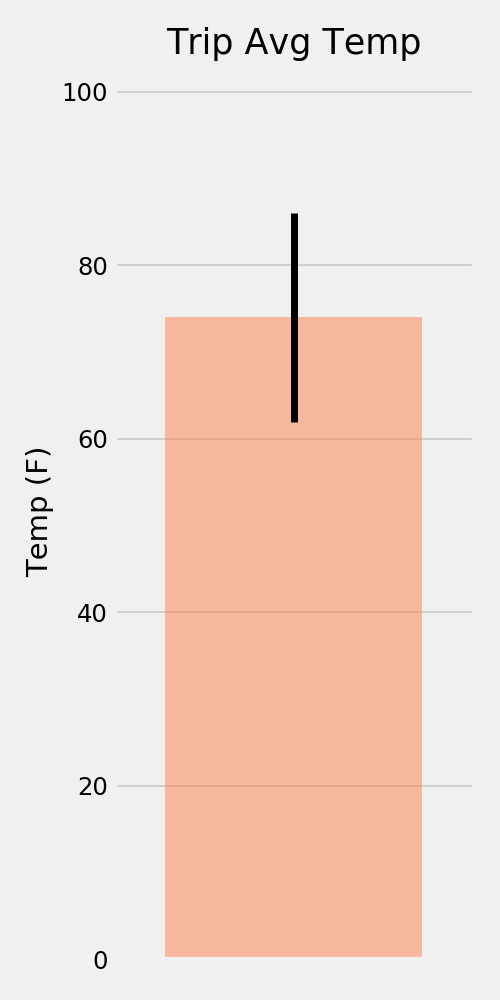

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


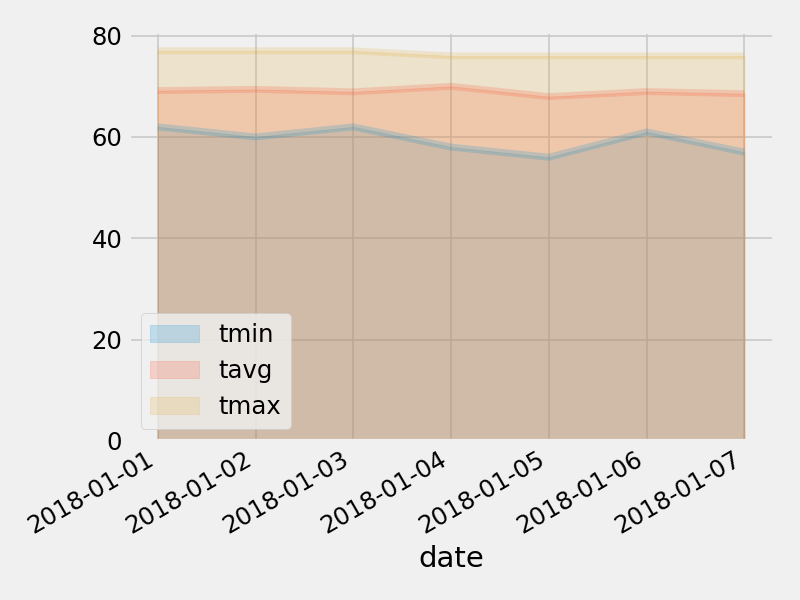

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
